# HW 2: Program Graph $\rightarrow$ Transition System

In this exercise, we will implement the formal concept of a Program Graph (PG) as we defined in class using Python classes. We will also implement the `to_transition_system()` method to convert a program graph into a transition system.


In [1]:
import sys
import otter
# try:
#   import otter
# except ImportError:
#     %pip install otter-grader
#     import otter

grader = otter.Notebook("HW2.ipynb")

## Challenge 1: Implementing the `ProgramGraph` class

### **Formal Definition**
A **Program Graph** (PG) is a tuple: $(Loc, Act, Effect, \rightarrow, Loc_0, g_0)$
where:
- $Loc$ is a finite set of program locations (control points).
- $Act$ is a set of actions (instructions that modify variables).
- $Effect$ is a function that applies an action to an environment and produces a new environment.
- $Transitions \subseteq Loc \times Cond \times Act \times Loc$ is a set of edges where:
    - $Cond$ is a condition that must hold for the transition.
    - $Act$ is the action that modifies the variables.
    - The edge represents moving from an **old location** to a **new location** under **condition** $Cond$ and **action** $Act$.
- $Loc_0 \subseteq Loc$ is a finite set of initial locations.
- $g_0$ is an initial condition on the program variables.
- $Eval$ is a function that evaluates conditions on variables.


### Example

Let’s define a **simple program graph** for a counter that increments from 0 to 2.

- $Loc = \{L_0, L_1, L_2\}$
- $Loc_0 = \{L_0\}$
- $Act = \{x += 1\}$
- $\rightarrow = \{(L_0, x < 2, x += 1, L_1), (L_1, x < 2, x += 1, L_2)\}$
- $g_0 = \{x = 0\}$

### Use `HashableDict`


In this exercise we will represent environments (variable assignments) as part of the states in a **Transition System**, which requires them to be **hashable** (so they can be used in sets and dictionaries). However, **Python dictionaries are mutable and not hashable by default**.

By defining `HashableDict`, which inherits from `dict` and implements `__hash__` using `frozenset(self.items())`, we create an **immutable, hashable representation** of environments while preserving dictionary-like behavior for easy lookups and modifications.


In [2]:
class HashableDict(dict):
    def __hash__(self):
        return hash(frozenset(self.items()))

Your task is to implement the `TransitionSystem` class in Python. The class should have the following methods:

In [6]:
from itertools import product
from typing import Dict, Set, Union

def generate_combinations(input_dict: Dict[str, Set[Union[str, bool, int, float]]]) -> Set[Dict[str, Union[str, bool, int, float]]]:
    """
    Generate a set of dictionaries for each combination of string-to-value mappings.

    :param input_dict: A dictionary mapping strings to sets of possible values.
    :return: A set of dictionaries, each representing a unique combination of mappings.
    """
    keys = input_dict.keys()
    values = input_dict.values()
    combinations = product(*values)
    
    return {HashableDict(zip(keys, combination)) for combination in combinations}

In [ ]:
from typing import Callable, Set, Tuple, Dict, List, Union
import matplotlib.pyplot as plt
import networkx as nx

# Add your imports here, don't forget to include your TransitionSystem class
import sys
sys.path.append("..") # Adds higher directory to python modules path.
from systems import TransitionSystem

Location = Union[str, Tuple]  # A state can be a string or a tuple (location, environment)
Action = str  # Actions are represented as strings
Condition = str # Conditions are represented as strings
Transition = Tuple[Location, Condition, Action, Location]  # (source_state, action, target_state)
Environment = Dict[str, Union[str, bool, int, float]]      # Variable assignments


class ProgramGraph:
    def __init__(
        self,
        locations: Set[Location],
        initial_locations: Set[Location],
        actions: Set[Action],
        transitions: Set[Transition],
        eval_fn: Callable[[Condition, Environment], bool],
        effect_fn: Callable[[Action, Environment], Environment],
        g0: Condition
    ):
        """
        A representation of a Program Graph.

        :param locations: Set of all program locations (Loc).
        :param initial_locations: Set of initial locations (Loc0).
        :param actions: Set of possible actions (Act).
        :param transitions: Set of transitions in the form (loc_from, condition, action, loc_to).
        :param eval_fn: Function to evaluate a condition string in an environment.
        :param effect_fn: Function to compute the new environment after applying an action.
        :param g0: Initial condition string for filtering valid starting environments.
        """
        self.Loc = set(locations)
        self.Loc0 = set(initial_locations)
        self.Act = set(actions)
        self.Transitions = set(transitions)
        self.eval_fn = eval_fn
        self.effect_fn = effect_fn
        self.g0 = g0

    def add_location(self, *locations: Location) -> "ProgramGraph":
        """Add one or more locations to the program graph."""
        self.Loc.update(locations)
        return self

    def add_action(self, *actions: Action) -> "ProgramGraph":
        """Add one or more actions to the program graph."""
        self.Act.update(actions)
        return self

    def add_transition(self, *transitions: Transition) -> "ProgramGraph":
        """
        Add one or more transitions to the program graph.

        Each transition must be a tuple: (loc_from, condition, action, loc_to).
        """
        for transition in transitions:
            if not isinstance(transition, tuple) or len(transition) != 4:
                raise ValueError(f"Invalid transition format: {transition}. Expected (loc_from, cond, action, loc_to).")
            loc_from, cond, action, loc_to = transition
            if loc_from not in self.Loc:
                raise ValueError(f"Location {loc_from} is not in the program graph.")
            if loc_to not in self.Loc:
                raise ValueError(f"Location {loc_to} is not in the program graph.")
            if action not in self.Act:
                raise ValueError(f"Action {action} is not in the program graph.")

            self.Transitions.add(transition)
        return self

    def add_initial_location(self, *locations: Location) -> "ProgramGraph":
        """Add one or more initial locations to the program graph."""
        for loc in locations:
            if loc not in self.Loc:
                raise ValueError(f"Cannot set initial location {loc}. Location is not in the set of locations.")
            self.Loc0.add(loc)
        return self

    def set_eval_fn(self, eval_fn: Callable[[Condition, Environment], bool]) -> "ProgramGraph":
        """Set the function used to evaluate conditions."""
        self.eval_fn = eval_fn
        return self

    def set_effect_fn(self, effect_fn: Callable[[Action, Environment], Environment]) -> "ProgramGraph":
        """Set the function used to apply actions to environments."""
        self.effect_fn = effect_fn
        return self

    def eval(self, condition: Condition, env: Environment) -> bool:
        """Evaluate a condition string in the given environment."""
        return self.eval_fn(condition, env)

    def effect(self, action: Action, env: Environment) -> Environment:
        """Apply an action to the environment and return the new environment."""
        return self.effect_fn(action, env)


    def valid_transitions(self, loc: Location, env: Environment, action: Action) -> List[Tuple[Location, Action, Location]]:
        """
        Return a list of valid transitions from a given location using the provided environment and action.
        """
        return [(loc_from, act, loc_to) for loc_from, cond, act, loc_to in self.Transitions
                if loc_from == loc and act == action and self.eval(cond, env)]

    def to_transition_system(self, vars: Dict[str, Set[Union[str, bool, int, float]]], labels: Set[Condition]) -> "TransitionSystem":
        """
        Construct and return a Transition System from the program graph.

        :param vars: A dictionary mapping variable names to their finite sets of possible values.
        :param labels: A set of atomic proposition strings to be used for labeling states.
        :return: A TransitionSystem instance corresponding to the program graph.
        """
        envs = generate_combinations(vars)
        conds = {cond for _, cond, _, _ in self.Transitions}

        states = {(loc,env) for loc in self.Loc for env in envs}
        actions = self.Act
        transitions = {
            ((loc_from, HashableDict(env)), act, (loc_to,HashableDict(self.effect(act, env)))) for env in envs for loc_from, cond, act, loc_to in self.Transitions
            if self.eval(cond, env)}
        initial_states = {(loc,env) for loc in self.Loc0 for env in envs 
                          if self.eval(self.g0, env)}
        atomic_props = self.Loc.union(conds)
        labeling_map = {state:{label for label in labels if self.eval(label, state[1])}.union({state[0]}) for state in states}

        return TransitionSystem(
            states=states,
            actions=actions,
            transitions=transitions,
            initial_states=initial_states,
            atomic_props=atomic_props,
            labeling_map=labeling_map
        )

    def __repr__(self):
                return (
            f"ProgramGraph(\n"
            f"  Loc: {self.Loc}\n"
            f"  Act: {self.Act}\n"
            f"  Transitions: {self.Transitions}\n"
            f"  Loc0: {self.Loc0}\n"
            f"  g0: {self.g0}\n"
            f")"
        )

    def plot(self):
        """
        Visualize the program graph as a directed graph using networkx and matplotlib.

        Nodes are locations. Edges are labeled with (condition, action).
        """
        G = nx.MultiDiGraph()

        # Add nodes
        for loc in self.Loc:
            G.add_node(loc, color='lightblue' if loc in self.Loc0 else 'white')

        # Add edges with (condition, action) labels
        for (loc_from, cond, action, loc_to) in self.Transitions:
            label = f"{cond} / {action}"
            G.add_edge(loc_from, loc_to, label=label)

        pos = nx.spring_layout(G, seed=42)  # consistent layout

        # Draw nodes with color
        node_colors = [G.nodes[n].get('color', 'white') for n in G.nodes]
        nx.draw_networkx_nodes(G, pos, node_color=node_colors, edgecolors='black')
        nx.draw_networkx_labels(G, pos)

        # Draw edges
        nx.draw_networkx_edges(G, pos, arrows=True)

        # Draw edge labels
        edge_labels = {(u, v): d['label'] for u, v, d in G.edges(data=True)}
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

        # Display
        plt.title("Program Graph")
        plt.axis('off')
        plt.tight_layout()
        plt.show()

## Example: Program Graph to Transition System Conversion

In the cell bellow, we define helper functions `eval_fn` and `effect_fn` using the Python interpreter. These functions are used to evaluate conditions and apply actions within a given environment. We then create a simple program graph for a counter that increments from 0 to 2 and convert it to a transition system.

States: {('L2', {'x': 0}), ('L2', {'x': 1}), ('L1', {'x': 1}), ('L0', {'x': 1}), ('L2', {'x': 2}), ('L1', {'x': 0}), ('L0', {'x': 0}), ('L1', {'x': 2}), ('L0', {'x': 2})}

Transitions:
(('L0', {'x': 0}), 'x += 1', ('L1', {'x': 1}))
(('L0', {'x': 1}), 'x += 1', ('L1', {'x': 2}))
(('L1', {'x': 1}), 'x += 1', ('L2', {'x': 2}))
(('L1', {'x': 0}), 'x += 1', ('L2', {'x': 1}))
('L2', {'x': 0})
x < 2
('L2', {'x': 1})
x < 2
('L1', {'x': 1})
x < 2
('L0', {'x': 1})
x < 2
('L2', {'x': 2})
x == 2
('L1', {'x': 0})
x < 2
('L0', {'x': 0})
x < 2
('L1', {'x': 2})
x == 2
('L0', {'x': 2})
x == 2


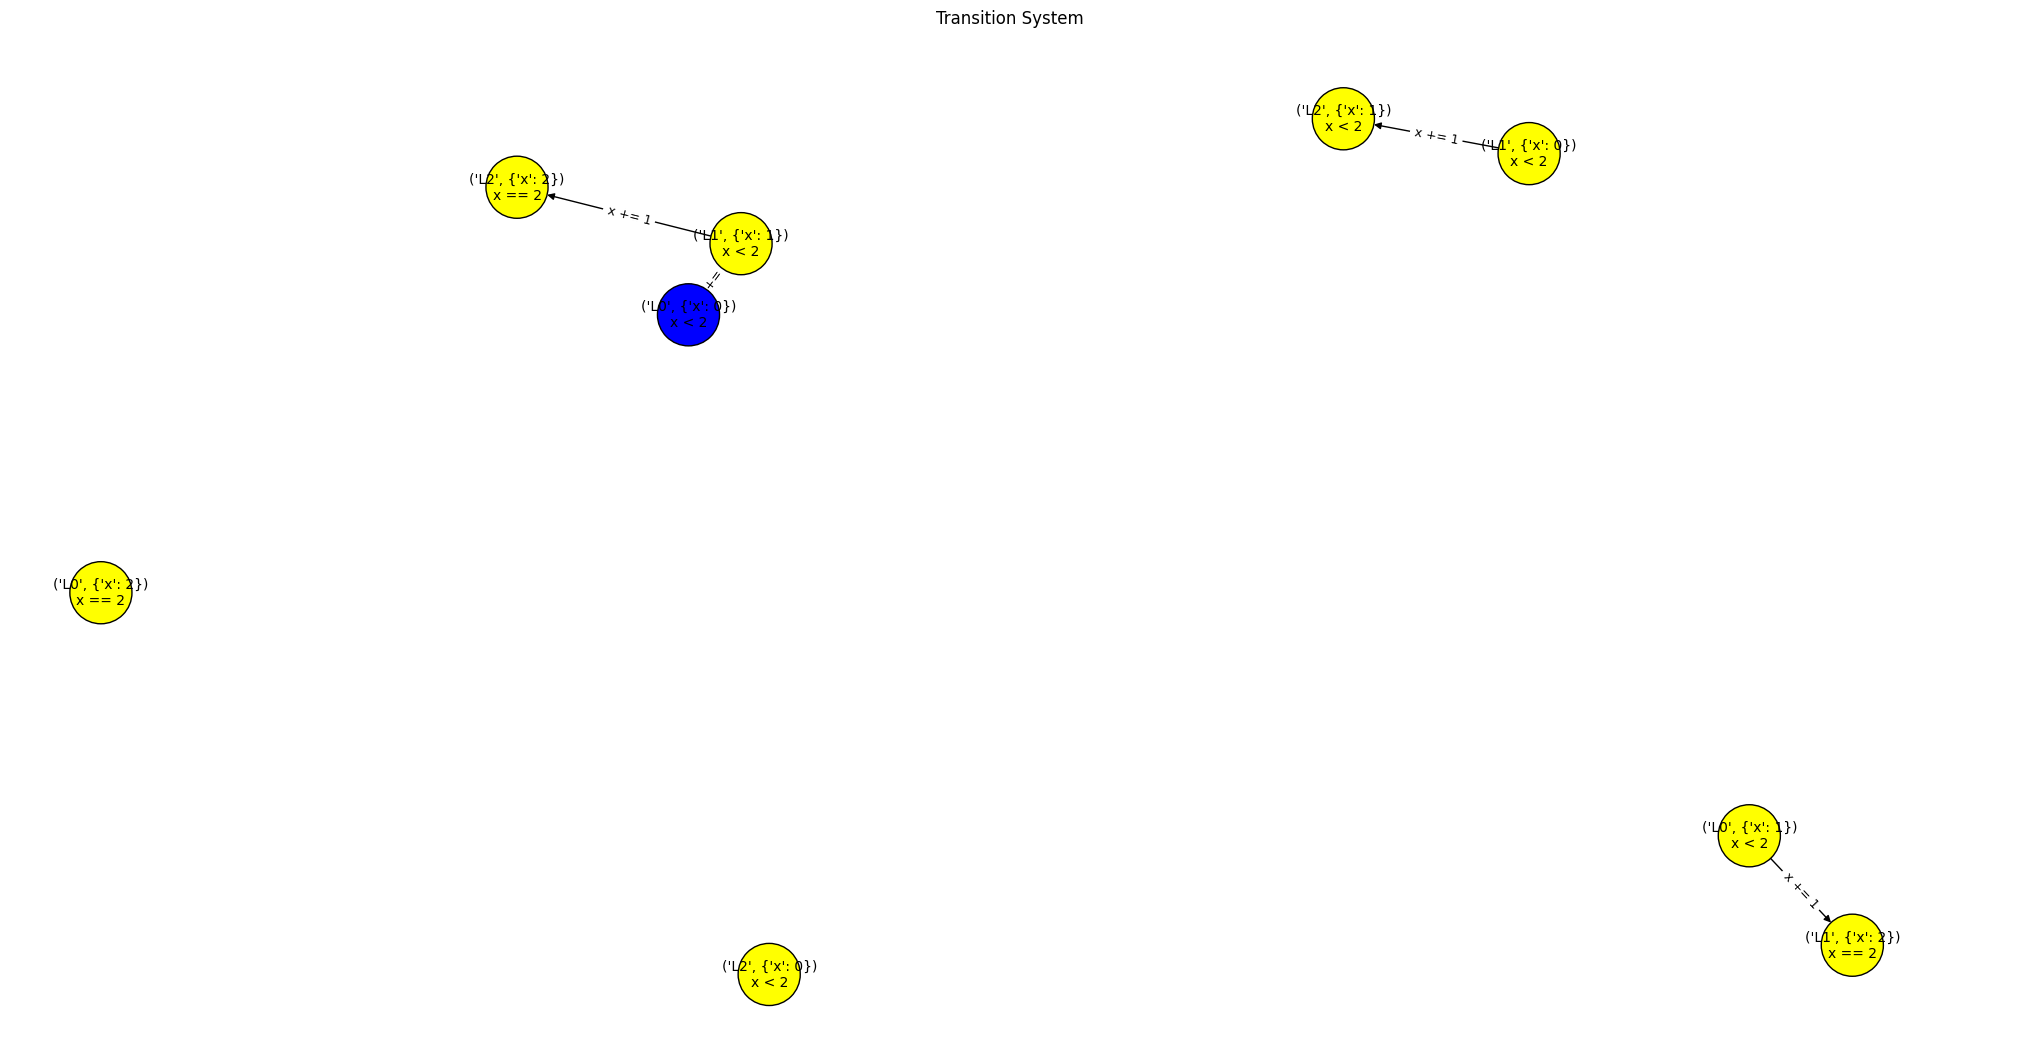

In [27]:
# Define helper functions for evaluation and effects
def eval_fn(cond, env):
    """Evaluates a condition string in a given environment dictionary."""
    try:
        return eval(cond, {}, env)
    except:
        return False

def effect_fn(action, env):
    """Applies an action (which modifies variables) and returns a new environment."""
    new_env = env.copy()
    try:
        exec(action, {}, new_env)
    except:
        pass
    return new_env

# Create a simple program graph for a counter that increments from 0 to 2
pg = ProgramGraph(
    locations={'L0', 'L1', 'L2'},
    initial_locations={'L0'},
    actions={'x += 1'},
    transitions={
        ('L0', 'x < 2', 'x += 1', 'L1'),
        ('L1', 'x < 2', 'x += 1', 'L2')
    },
    eval_fn=eval_fn,
    effect_fn=effect_fn,
    g0='x == 0'  # Initial condition: x starts at 0
)

# Convert to transition system
vars = {'x': {0, 1, 2}}  # Possible values for x
labels = {'x < 2', 'x == 2'}  # Properties we want to track
ts = pg.to_transition_system(vars, labels)

# Print the states and transitions
print("States:", ts.S)
print("\nTransitions:")
for transition in ts.Transitions:
    print(transition)

ts.plot(figsize=(20,10))

In [28]:
grader.check("q1")

q1 results:
    q1 - 1 result:
        ❌ Test case failed
        Trying:
            def create_ts():
                def eval_fn(cond, env):
                    """Evaluates a condition string in a given environment dictionary."""
                    try:
                        return eval(cond, {}, env)
                    except:
                        return False
                def effect_fn(action, env):
                    """Applies an action (which modifies variables) and returns a new environment."""
                    new_env = env.copy()
                    try:
                        exec(action, {}, new_env)
                    except:
                        pass
                    return new_env
                pg = ProgramGraph(locations={'L0', 'L1'}, initial_locations={'L0'}, actions={'x += 1', 'x -= 1'}, transitions={('L0', 'x > 0', 'x -= 1', 'L1'), ('L1', 'x < 5', 'x += 1', 'L0')}, eval_fn=eval_fn, effect_fn=effect_fn, g0='x >= 2')
                vars = {'x': {0, 1, 2, 3, 4, 5}}
                labels = {'x > 0', 'x < 5'}
                ts = pg.to_transition_system(vars, labels)
                return ts
        Expecting nothing
        ok
        Trying:
            def test_states_are_tuples():
                """Test that all states in the Transition System are correctly formatted as (loc, env)."""
                ts = create_ts()
                assert all((isinstance(state, tuple) and len(state) == 2 for state in ts.S)), 'States must be tuples (loc, env)'
                assert all((isinstance(state[1], HashableDict) for state in ts.S)), 'Environment must be a HashableDict'
                print('States are correctly formatted as (loc, env)')
        Expecting nothing
        ok
        Trying:
            def test_initial_states_valid():
                """Test that initial states satisfy g0: x >= 2"""
                ts = create_ts()
                for state in ts.I:
                    (loc, env) = state
                    assert loc in {'L0', 'L1'}, 'Initial state location must be within program locations'
                    assert eval('x >= 2', {}, env), f"Initial condition g0='x >= 2' must hold, but failed for state {state}"
                print('Initial states are valid')
        Expecting nothing
        ok
        Trying:
            def test_valid_transitions():
                """Test that all transitions follow the rules of the program graph and correctly update environments."""
                ts = create_ts()
                for (s_from, action, s_to) in ts.Transitions:
                    (loc_from, env_from) = s_from
                    (loc_to, env_to) = s_to
                    assert loc_from in {'L0', 'L1'}, f'Transition from an invalid location: {loc_from}'
                    assert loc_to in {'L0', 'L1'}, f'Transition to an invalid location: {loc_to}'
                    assert action in {'x += 1', 'x -= 1'}, f'Invalid action in transition: {action}'
                    expected_env_to = HashableDict(env_from.copy())
                    exec(action, {}, expected_env_to)
                    assert env_to == expected_env_to, f'Action {action} did not produce expected state: got {env_to}, expected {expected_env_to}'
                print('All transitions are valid')
        Expecting nothing
        ok
        Trying:
            def test_labeling_function():
                """Test that the labeling function correctly assigns labels to states."""
                ts = create_ts()
                for (state, labels) in ts._L.items():
                    (loc, env) = state
                    expected_labels = {loc} | {l for l in {'x > 0', 'x < 5'} if eval(l, {}, env)}
                    assert labels == expected_labels, f'Labeling mismatch for state {state}: expected {expected_labels}, got {labels}'
                print('Labeling function is correct')
        Expecting nothing
        ok
        Trying:
            def test_reachability():
                """Test tha

## 🧠 Question 2: Modeling a Multi-Threaded Counter with a Program Graph

### 🔍 Objective
In this task, you will implement a function that constructs a **Program Graph** representing a simplified **multi-threaded counter protocol**.

Each of the `n_threads` executes a fixed four-step sequence to increment a shared variable `x`. The increment operation is broken into atomic actions using a temporary variable `tmp_i` and a counter variable `count_i` for each thread:

1. `count_i += 1` – mark the start of a new iteration
2. `tmp_i = x` – read
3. `tmp_i += 1` – increment
4. `x = tmp_i` – write

The goal is to repeat this protocol **up to `n_repeats` times per thread**. Once a thread completes all 4 steps, it may loop back to the beginning **only if `count_i < n_repeats`**.


### **🧩 Task 1: Program Graph Definition**

You are required to implement the function:

```python
def counter_program_graph(n_threads: int, n_repeats: int) -> ProgramGraph:
    ...
```

The function should return a valid `ProgramGraph` object with the following properties:

#### 🔹 Locations (`Loc`)
- Each location is a string of length `n_threads`, where each character is in `{1, 2, 3, 4}`.
- The `i`-th character indicates the program counter of thread `i`, representing its progress in the 4-step protocol.
- All combinations of `{1, 2, 3, 4}^n_threads` should be included.

#### 🔹 Initial Location (`Loc0`)
- All threads start at step 1: `'1' * n_threads`

#### 🔹 Actions (`Act`)
Each thread has exactly 4 actions:
1. `count_i += 1` (track iteration count)
2. `tmp_i = x` (read)
3. `tmp_i += 1` (increment)
4. `x = tmp_i` (write)

Total actions: `4 * n_threads`

#### 🔹 Transitions (`Transitions`)
- If a thread is at step 1:
  - It performs `count_i += 1` and may only proceed **if `count_i < n_repeats`**.
- If a thread is at step 2 or 3:
  - It progresses unconditionally using its corresponding action.
- If a thread is at step 4:
  - It always performs `x = tmp_i` and then loops back to step 1.

Each transition updates the corresponding thread's program counter by one (or loops to 1 after step 4).

#### 🔹 Initial Condition (`g0`)
All variables are initialized to 0:
```
x == 0 and tmp_1 == 0 and count_1 == 0 and tmp_2 == 0 and count_2 == 0 ... and tmp_n == 0 and count_n == 0
```

---



### 🔧 Example

For `n_threads = 2` and `n_repeats = 3`, the constructed program graph will include:

#### Locations
All combinations of two digits from `{1, 2, 3, 4}`:
```
{'11', '12', '13', '14', '21', '22', '23', '24', '31', '32', '33', '34', '41', '42', '43', '44'}
```

Each digit represents the program counter (PC) of a thread.
For example, `'24'` means:
- Thread 1 is at PC = 2
- Thread 2 is at PC = 4

#### Actions
Each thread has 4 actions. For 2 threads:
```
[
  'count_1 += 1', 'tmp_1 = x', 'tmp_1 += 1', 'x = tmp_1',
  'count_2 += 1', 'tmp_2 = x', 'tmp_2 += 1', 'x = tmp_2'
]
```

#### Initial Location
```python
'11'
```
Both threads start at PC = 1.

#### Transitions
Each thread moves forward in its 4-step sequence or loops back to 1:

- `'11'` → `'21'` via action `'count_1 += 1'` **if `count_1 < 3`**
- `'21'` → `'31'` via action `'tmp_1 = x'`
- `'31'` → `'41'` via action `'tmp_1 += 1'`
- `'41'` → `'11'` via action `'x = tmp_1'`

These transitions apply similarly for thread 2. All transitions are independent and interleaved.

#### Initial Condition
All variables initialized to 0:
```python
x == 0 and tmp_1 == 0 and count_1 == 0 and tmp_2 == 0 and count_2 == 0
```


In [ ]:
# Add your imports here
...

def eval_fn(cond, env):
    """Evaluates a condition string in a given environment dictionary."""
    try:
        return eval(cond, {}, env)
    except:
        return False

def effect_fn(action, env):
    """Applies an action (which modifies variables) and returns a new environment."""
    new_env = env.copy()
    try:
        exec(action, {}, new_env)
    except:
        pass
    return new_env

def counter_program_graph(n_threads: int, n_repeats: int) -> ProgramGraph:
    ...

## 🧠 Task 2: Determining Final Values of `x`

### 🔍 Objective

Your task is to analyze the transition system generated from the program graph (created in Task 1) and determine **all possible values** the variable `x` may have when the program **terminates**.

A program execution is considered **terminated** when **all threads have returned to the first step** of their 4-step protocol and **no further transitions are possible** (i.e., the guard `count_i < n_repeats` no longer holds for any thread `i`).

---

### 🎯 Goal

Implement the following function:

```python
def final_x_values(ts: TransitionSystem) -> List[int]:
    """
    Given a transition system created from the counter program graph,
    return a sorted list of all possible final values of x at program termination.
    """
```

The function should return a **sorted list** (from lowest to highest) of all values `x` can take in **terminal states**.

---

### 📌 Terminal State Criteria

A state `(location, environment)` is terminal if:

- The location is `'1' * n_threads` (i.e., all threads are at step 1), **and**
- For every thread `i`, the condition `count_i < n_repeats` evaluates to **False** in the given environment.

You should extract the value of `x` from each such terminal environment.

---

### 🧪 Example

If `n_threads = 2` and `n_repeats = 2`, the program may terminate in multiple ways, resulting in different possible values of `x`, e.g.:

```python
[1, 2, 3, 4]
```

This means the program could terminate with `x in [1, 2, 3, 4]` when all threads complete exactly `2` iterations.
(In other configurations, there may be non-determinism allowing early termination with smaller values.)


In [ ]:
def list_x_values(n_threads, n_repeats):
    pg = counter_program_graph(n_threads=n_threads, n_repeats=n_repeats)
    ...

In [ ]:
grader.check("q2")

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export(pdf=False)